[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/multiple-schemas.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239434-lesson-3-multiple-schemas)


# Multiple Schemas

## Review

We just covered state schema and reducers.

Typically, all graph nodes communicate with a single schema. 

Also, this single schema contains the graph's input and output keys / channels.

## Goals

But, there are cases where we may want a bit more control over this:

* Internal nodes may pass information that is *not required* in the graph's input / output.

* We may also want to use different input / output schemas for the graph. The output might, for example, only contain a single relevant output key.

We'll discuss a few ways to customize graphs with multiple schemas.


In [2]:
%%capture --no-stderr
%pip install --quiet -U langgraph

from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Private State

First, let's cover the case of passing [private state](https://langchain-ai.github.io/langgraph/how-tos/pass_private_state/) between nodes.

This is useful for anything needed as part of the intermediate working logic of the graph, but not relevant for the overall graph input or output.

We'll define an `OverallState` and a `PrivateState`.

`node_2` uses `PrivateState` as input, but writes out to `OverallState`.


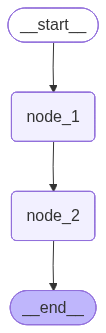

---Node 1---
---Node 2---


{'foo': 3}

In [ ]:
class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    baz: int

def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    return {"baz": state['foo'] + 1}

def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    return {"foo": state['baz'] + 1}

builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"foo": 1})


`baz` is only included in `PrivateState`.

`node_2` uses `PrivateState` as input, but writes out to `OverallState`.

So, we can see that `baz` is excluded from the graph output because it is not in `OverallState`.


## Input / Output Schema

By default, `StateGraph` takes in a single schema and all nodes are expected to communicate with that schema. 

However, it is also possible to [define explicit input and output schemas for a graph](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/?h=input+outp).

Often, in these cases, we define an "internal" schema that contains *all* keys relevant to graph operations.

But, we use specific `input` and `output` schemas to constrain the input and output.

First, let's just run the graph with a single schema.


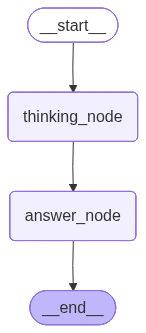

{'question': 'hi', 'answer': 'bye Lance', 'notes': '... his name is Lance'}

In [ ]:
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

# Nodes
def thinking_node(state: OverallState):
    return {"answer": "bye", "notes": "... his name is Lance"}

def answer_node(state: OverallState):
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)
graph = graph.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"question":"hi"})


Notice that the output of invoke contains all keys in `OverallState`.


Now, let's use a specific `input` and `output` schema with our graph.

Here, `input` / `output` schemas perform *filtering* on what keys are permitted on the input and output of the graph. 

In addition, we can use a type hint `state: InputState` to specify the input schema of each of our nodes.

This is important when the graph is using multiple schemas.

We use type hints below to, for example, show that the output of `answer_node` will be filtered to `OutputState`. 


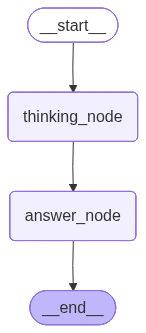

{'answer': 'bye Lance'}

In [ ]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: InputState):
    return {"answer": "bye", "notes": "... his is name is Lance"}

def answer_node(state: OverallState) -> OutputState:
    return {"answer": "bye Lance"}

graph = StateGraph(
    OverallState, 
    input_schema=InputState, 
    output_schema=OutputState
)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)
graph = graph.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"question":"hi"})


## CUSTOM TWEAKS: CURRENCY CONVERTER & EVENT PREFERENCE PROCESSOR

### Tweak 1: Currency Converter with Private Schemas

This graph demonstrates private state handling:
- **Input**: Currency amount and target currency
- **Private State**: Exchange rates and intermediate calculations
- **Output**: Only the converted amount

### Tweak 2: Event Preference Collector with Schema Filtering

This graph collects user event preferences internally and outputs only a summary:
- **Input**: User event preferences (multiple fields)
- **Private State**: Preference analytics and processing data
- **Output**: Only a summary message to user


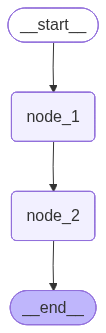

---Node 1---
---Node 2---


{'foo': 2}

In [ ]:
from typing import Annotated
from operator import add

def reduce_list(left: list | None, right: list | None) -> list:
    return (left or []) + (right or [])

class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    baz: Annotated[list[int], reduce_list]

def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    return {"baz": [state['foo'] + 1]}

def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    return {"foo": sum(state['baz'])}

builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"foo": 1})


## TWEAK 1: Currency Converter with Private Schemas

A currency converter that uses private state for intermediate exchange rate calculations.


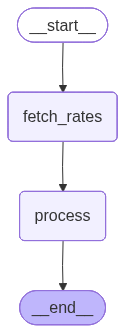

---Fetching Exchange Rates (Private State)---
---Processing Conversion---

=== Currency Converter Result ===
Converted Amount: 91.98 EUR


In [ ]:
class CurrencyInputState(TypedDict):
    amount: float
    target_currency: str

class CurrencyPrivateState(TypedDict):
    exchange_rates: dict
    calculated_rate: float
    conversion_fees: float

class CurrencyOverallState(TypedDict):
    amount: float
    target_currency: str
    exchange_rates: dict
    calculated_rate: float
    conversion_fees: float
    converted_amount: float

class CurrencyOutputState(TypedDict):
    converted_amount: float
    target_currency: str

def fetch_exchange_rates(state: CurrencyInputState) -> CurrencyPrivateState:
    print("---Fetching Exchange Rates (Private State)---")
    exchange_rates = {"USD": 1.0, "EUR": 0.92, "GBP": 0.79, "JPY": 149.50}
    calculated_rate = exchange_rates.get(state['target_currency'], 1.0)
    return {
        "exchange_rates": exchange_rates,
        "calculated_rate": calculated_rate,
        "conversion_fees": calculated_rate * 0.02  # 2% fee
    }

def process_conversion(state: CurrencyOverallState):
    print("---Processing Conversion---")
    converted = state['amount'] * state['calculated_rate']
    final_amount = converted - state['conversion_fees']
    return {"converted_amount": final_amount}

currency_graph = StateGraph(
    CurrencyOverallState,
    input_schema=CurrencyInputState,
    output_schema=CurrencyOutputState
)
currency_graph.add_node("fetch_rates", fetch_exchange_rates)
currency_graph.add_node("process", process_conversion)
currency_graph.add_edge(START, "fetch_rates")
currency_graph.add_edge("fetch_rates", "process")
currency_graph.add_edge("process", END)
currency_graph = currency_graph.compile()

display(Image(currency_graph.get_graph().draw_mermaid_png()))

result = currency_graph.invoke({"amount": 100.0, "target_currency": "EUR"})
print("\n=== Currency Converter Result ===")
print(f"Converted Amount: {result['converted_amount']:.2f} {result['target_currency']}")


## TWEAK 2: Event Preference Collector with Schema Filtering

A preference collection system that processes user event preferences internally and outputs only a summary message.


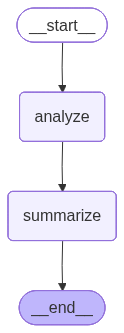

---Analyzing User Preferences (Private State)---
---Generating Summary Message---

=== Event Preference Collector Result ===
Hi Alice! We found 3 matching event topics: AI, Machine Learning, Data Science. Your intermediate level and 3 available slots match well. Check your personalized event recommendations!


In [ ]:
class EventPreferenceInputState(TypedDict):
    user_name: str
    interested_topics: list[str]
    experience_level: str
    availability: list[str]

class EventPreferencePrivateState(TypedDict):
    topic_scores: dict
    experience_multiplier: float
    availability_slots: int
    recommendation_data: str

class EventPreferenceOverallState(TypedDict):
    user_name: str
    interested_topics: list[str]
    experience_level: str
    availability: list[str]
    topic_scores: dict
    experience_multiplier: float
    availability_slots: int
    recommendation_data: str
    summary_message: str

class EventPreferenceOutputState(TypedDict):
    summary_message: str

def analyze_preferences(state: EventPreferenceInputState) -> EventPreferencePrivateState:
    print("---Analyzing User Preferences (Private State)---")
    
    topic_scores = {topic: len(state['interested_topics']) for topic in state['interested_topics']}
    
    experience_map = {"beginner": 1.0, "intermediate": 1.5, "expert": 2.0}
    experience_multiplier = experience_map.get(state['experience_level'], 1.0)
    
    availability_slots = len(state['availability'])
    
    recommendation_data = f"User prefers {len(state['interested_topics'])} topics, available {availability_slots} slots"
    
    return {
        "topic_scores": topic_scores,
        "experience_multiplier": experience_multiplier,
        "availability_slots": availability_slots,
        "recommendation_data": recommendation_data
    }

def generate_summary(state: EventPreferenceOverallState) -> EventPreferenceOutputState:
    print("---Generating Summary Message---")
    
    summary = (
        f"Hi {state['user_name']}! "
        f"We found {len(state['interested_topics'])} matching event topics: {', '.join(state['interested_topics'])}. "
        f"Your {state['experience_level']} level and {state['availability_slots']} available slots match well. "
        f"Check your personalized event recommendations!"
    )
    
    return {"summary_message": summary}

event_graph = StateGraph(
    EventPreferenceOverallState,
    input_schema=EventPreferenceInputState,
    output_schema=EventPreferenceOutputState
)
event_graph.add_node("analyze", analyze_preferences)
event_graph.add_node("summarize", generate_summary)
event_graph.add_edge(START, "analyze")
event_graph.add_edge("analyze", "summarize")
event_graph.add_edge("summarize", END)
event_graph = event_graph.compile()

display(Image(event_graph.get_graph().draw_mermaid_png()))

result = event_graph.invoke({
    "user_name": "Alice",
    "interested_topics": ["AI", "Machine Learning", "Data Science"],
    "experience_level": "intermediate",
    "availability": ["Monday", "Wednesday", "Friday"]
})

print("\n=== Event Preference Collector Result ===")
print(result['summary_message'])
